In [1]:
import yaml
import pandas as pd
import time
from backend.utils.data_preprocessor import DataPreprocessor
from backend.utils.feature_provider import FeatureProvider


with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

interval: str = config['feature_engineering']['time_series_interval']

training_file_path: str = f"../data/twelvedata/time series ({interval})/ABBV_time_series.csv"
validation_file_path: str = f"../data/twelvedata/time series ({interval})/AAPL_time_series.csv"

start_time = time.time()

training_df = pd.read_csv(training_file_path)
validation_df = pd.read_csv(validation_file_path)


In [2]:
lookback_period: int = config['preprocess']['lookback_period']
target: str = config['preprocess']['target']
trend_length: int = config['preprocess']['trend_length']

training_feature_provider = FeatureProvider(training_df)
training_feature_time_series = training_feature_provider.feature_time_series

validation_feature_provider = FeatureProvider(validation_df)
validation_feature_time_series = validation_feature_provider.feature_time_series

In [3]:
training_preprocessor = DataPreprocessor(time_series=training_feature_time_series, lookback_period=lookback_period, target_feature=target, trend_length=trend_length, fit_scaler=True)
validation_preprocessor = DataPreprocessor(time_series=validation_feature_time_series, lookback_period=lookback_period, target_feature=target, trend_length=trend_length, fit_scaler=False)
training_preprocessor.feature_data.head(15)

,open,high,low,close,volume,adx,atr,sma,ema,rsi,macd_signal,percent_b,day,hour
datetime,,,,,,,,,,,,,,
2021-03-15 11:30:00,109.88,110.00,109.51,109.99,499813,16.95,0.65,108.39,108.66,73.48,0.11,1.31,0,11
2021-03-15 12:30:00,109.98,110.33,109.88,110.06,419541,18.94,0.64,108.63,108.93,74.29,0.16,1.16,0,12
2021-03-15 13:30:00,110.07,110.36,109.77,110.24,796992,21.13,0.63,108.89,109.15,74.82,0.22,1.06,0,13
2021-03-15 14:30:00,110.25,110.27,109.92,109.99,519471,22.83,0.63,109.15,109.37,76.18,0.27,1.02,0,14
2021-03-15 15:30:00,109.98,110.35,109.83,110.24,502889,24.42,0.61,109.36,109.50,70.49,0.33,0.89,0,15
2021-03-16 09:30:00,110.07,110.92,109.90,110.74,1021244,25.60,0.60,109.58,109.64,72.69,0.38,0.90,1,9
2021-03-16 10:30:00,110.71,111.07,110.43,110.53,709902,27.38,0.63,109.84,109.86,76.46,0.43,0.96,1,10
2021-03-16 11:30:00,110.54,110.77,110.37,110.44,391844,29.18,0.63,110.11,110.00,71.96,0.48,0.86,1,11
2021-03-16 12:30:00,110.45,110.51,110.12,110.24,354152,30.65,0.61,110.23,110.09,70.06,0.52,0.81,1,12


In [6]:
from backend.models.stock_trend_lstm_model import StockTrendLSTMModel

X_train = training_preprocessor.feature_data_batched
X_val = validation_preprocessor.feature_data_batched
y_train = training_preprocessor.label_data
y_val = validation_preprocessor.label_data

y_train.mean(), y_val.mean()

(0.5615633859862292, 0.5425273390036452)

In [4]:
input_shape = (X_train.shape[1], X_train.shape[2])
epochs: int = config["model"]["epochs"]
batch_size: int = config["model"]["batch_size"]
my_model = StockTrendLSTMModel(input_shape, X_train, y_train, X_val, y_val, epochs, batch_size)
history = my_model.train()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            13000     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 33251 (129.89 KB)
Trainable params: 33251 (129.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


15

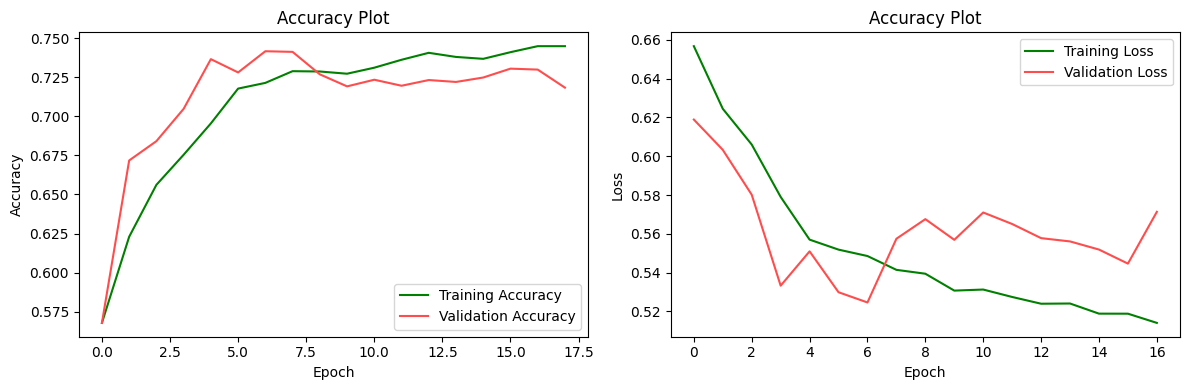

In [5]:
from backend.utils.visualizing_service import plot_model_accuracy
plot_model_accuracy(history)